# Colima Seperate GS Inversion

In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df = pd.read_csv(filename)

phi_labels = [
    "[-5,-4)",
    "[-4,-3)" ,
    "[-3,-2)",
    "[-2,-1)",
    "[-1,0)",
    "[0,1)",
    "[1,2)",
    "[2,3)",
    "[3,4)"
]

ventx = 645110
venty = 2158088

raw_df["Easting"] = raw_df["Easting"] - ventx
raw_df["Northing"] = raw_df["Northing"] - venty

for phi in phi_labels:
    raw_df[phi] = (raw_df[phi].values)*100
    
raw_df["radius"] = np.sqrt(raw_df["Easting"]**2 + raw_df["Northing"]**2)

display(raw_df.head())

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
0,VF95-06a,3133,9522,417.20,40,0.0,11.0,21.0,22.0,23.0,17.0,4.0,0.0,0.0,10024.179418
1,VF95-08a,1907,8096,312.90,30,1.0,13.0,19.0,24.0,25.0,16.0,3.0,0.0,0.0,8317.563646
2,VF97-20Q,5500,8723,208.60,20,2.0,7.0,14.0,21.0,26.0,21.0,6.0,1.0,1.0,10312.164128
3,VF98-01a3,2665,9054,239.89,23,4.0,13.0,18.0,21.0,23.0,15.0,3.0,0.0,0.0,9438.068711
4,VF98-02a,1154,7735,156.45,15,1.0,12.0,19.0,23.0,24.0,17.0,3.0,0.0,0.0,7820.610015


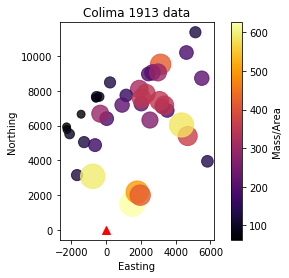

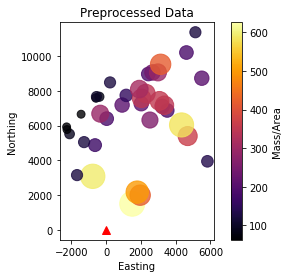

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()
obs_df["radius"] = np.sqrt(obs_df["Easting"]**2 + obs_df["Northing"]**2)

obs_df = obs_df.sort_values(by=['radius'])\

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

# Uncomment to drop proximal points
# obs_df = obs_df[obs_df["radius"]>3500]

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
grid = obs_df[["Easting", "Northing"]].copy()
grid["Elevation"] = np.zeros(len(grid))
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

# Order of these 3 commands matter
t2_df["radius"] = np.sqrt(t2_df["Easting"]**2 + t2_df["Northing"]**2)
t2_df = t2_df.sort_values(by=['radius'])
t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values*100

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,0,732.730,23.15290,25.4668,22.2407,15.7304,8.99492,3.44384,0.823464,0.136596,0.010359,2124.861643,117.086929
18,1957,1997,0,691.154,21.35410,24.7682,22.4602,16.5434,9.82586,3.90198,0.968656,0.164832,0.012894,2796.043276,165.664909
17,1787,2173,0,709.841,21.21370,24.7100,22.4801,16.6062,9.88889,3.93999,0.980849,0.167220,0.013114,2813.413940,141.786713
37,-770,3082,0,301.066,13.80220,19.2173,22.1297,20.4626,14.72470,7.12663,2.105690,0.398324,0.032906,3176.731654,50.641032
31,-1673,3152,0,149.680,9.51561,14.8613,20.3208,22.2637,18.49420,10.31720,3.459940,0.706562,0.060698,3568.477687,119.590924


In [9]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

# Order of these 3 commands matter
t2_const_df["radius"] = np.sqrt(t2_const_df["Easting"]**2 + t2_const_df["Northing"]**2)
t2_const_df = t2_const_df.sort_values(by=['radius'])
t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]*100

display(t2_const_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,2500,1394.460,17.2005,24.2121,24.7779,18.9162,10.8457,3.58293,0.449327,0.015328,0.000028,2124.861643,222.828380
18,1957,1997,2500,1216.150,14.0160,22.3619,24.8640,20.2838,12.7356,4.93885,0.769130,0.030705,0.000063,2796.043276,291.502876
17,1787,2173,2500,1251.000,13.8770,22.2837,24.8861,20.3522,12.8046,4.98427,0.780754,0.031310,0.000064,2813.413940,249.880153
37,-770,3082,2500,359.399,14.8025,22.8299,24.5313,19.4545,12.2828,5.13528,0.922533,0.041096,0.000091,3176.731654,60.452978
31,-1673,3152,2500,134.301,15.3664,23.3283,24.4813,18.8191,11.7036,5.16746,1.079070,0.054478,0.000132,3568.477687,107.303452


In [10]:
config = {}
with open("data/colima/colima_config.txt") as f:
    for line in f:
        line = line.strip()
        if not line=="" and not line.startswith("#"):
            (key, val) = line.split()
            config[str(key)] = float(val)

config["COL_STEPS"] = int(config["COL_STEPS"])
config["PART_STEPS"] = int(config["PART_STEPS"])

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}




# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,1024.0,"[-5,-4)",-5.0,0.068338,-4.0
1,-3.5,1024.0,"[-4,-3)",-4.0,0.109203,-3.0
2,-2.5,1024.0,"[-3,-2)",-3.0,0.146694,-2.0
3,-1.5,1024.0,"[-2,-1)",-2.0,0.165650,-1.0
4,-0.5,1024.0,"[-1,0)",-1.0,0.157243,0.0
5,0.5,1233.5,"[0,1)",0.0,0.125474,1.0
6,1.5,1443.0,"[1,2)",1.0,0.084166,2.0
7,2.5,1652.5,"[2,3)",2.0,0.047459,3.0
8,3.5,1862.0,"[3,4)",3.0,0.022496,4.0


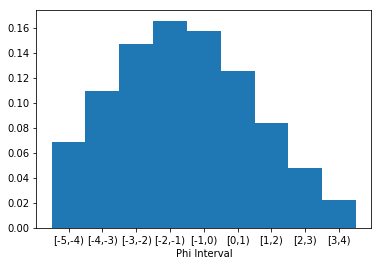

In [11]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [12]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values*100
display(forward_df.head())

Forward Sim time: 0.01562 seconds
Dataframe Merge time: 0.00000 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.03125 seconds
Total time: 0.04688 seconds


,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,17.023654,24.058691,24.746126,19.010648,10.986457,3.680616,0.476505,0.017266,0.000036,1316.804462,2124.861643,210.419377
1,1997,1957,13.849036,22.187896,24.802962,20.364657,12.884741,5.062941,0.813217,0.034469,0.000080,1148.987823,2796.043276,275.404560
2,2173,1787,13.800371,22.209864,24.864958,20.379976,12.855621,5.043105,0.811521,0.034502,0.000081,1166.987337,2813.413940,233.099101
3,3082,-770,15.561092,23.674710,24.901902,19.059630,11.448421,4.522511,0.794749,0.036892,0.000093,300.904559,3176.731654,50.613877
4,3152,-1673,16.255639,24.321103,24.942842,18.429623,10.768184,4.367639,0.869463,0.045380,0.000126,111.014810,3568.477687,88.698314


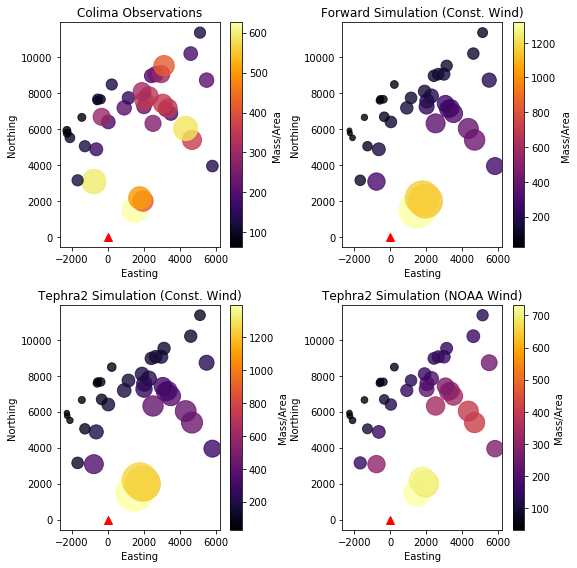

c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


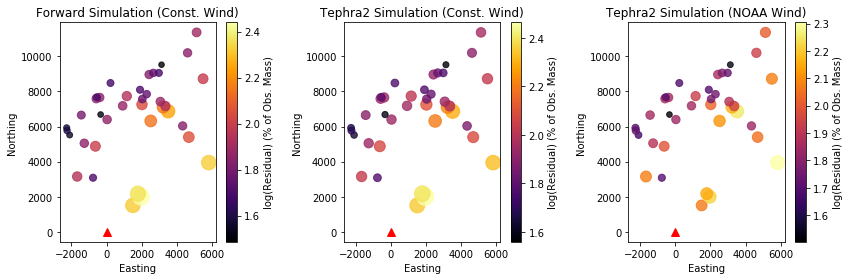

In [13]:
fig, axs = plt.subplots(2,2, figsize=(
        8,8), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[3])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
            title="Forward Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[2])




plt.tight_layout()
plt.show()

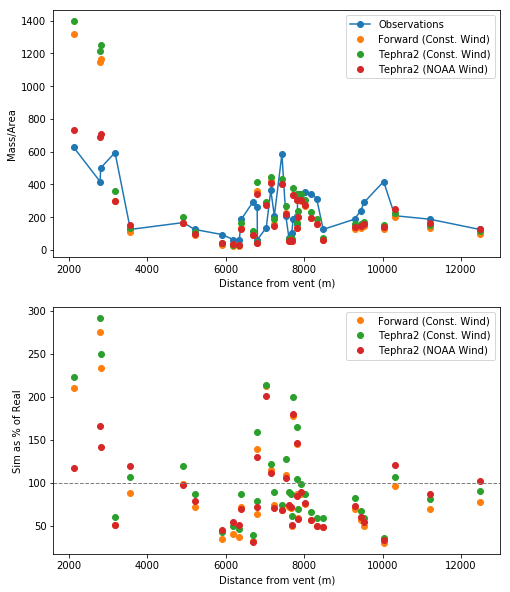

In [14]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========[-5,-4)========
a* = -3.50302	b* = 1.82204            	h1* = 2.50879
a = 1.03011	b = 7.18443	h1 = 27655.66323
Success: True, Optimization terminated successfully.
Iterations: 158
SSE: 214.00430843965023


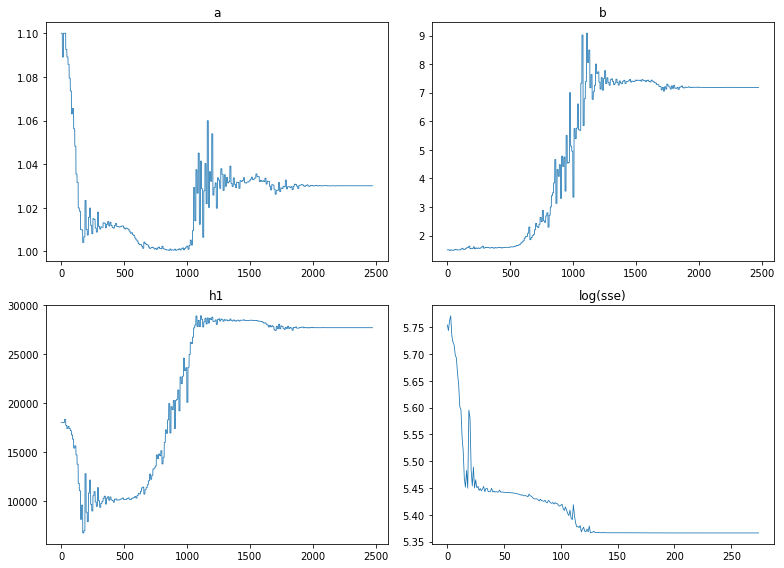

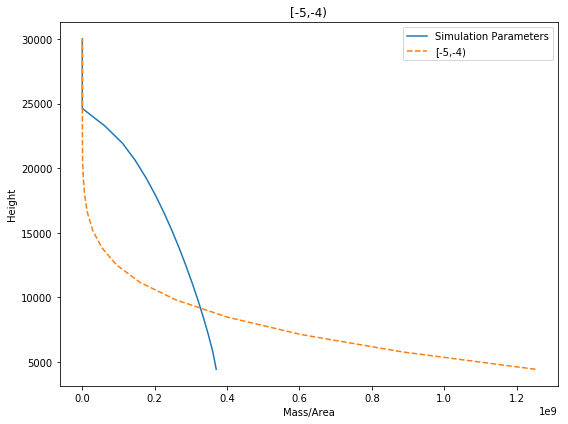

========[-4,-3)========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:426: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = -3.43270	b* = 2.03081            	h1* = 2.30261
a = 1.03230	b = 8.62026	h1 = 27145.20172
Success: True, Optimization terminated successfully.
Iterations: 172
SSE: 465.03388058557186


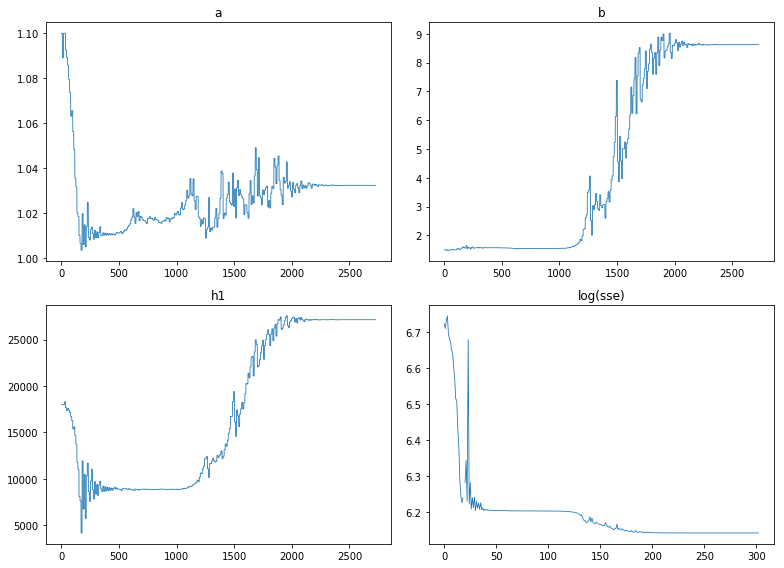

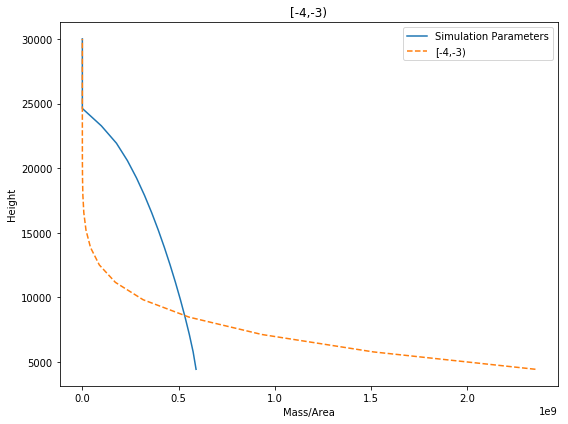

========[-3,-2)========
a* = -3.51199	b* = 1.41182            	h1* = 2.48819
a = 1.02984	b = 5.10342	h1 = 27608.87843
Success: True, Optimization terminated successfully.
Iterations: 138
SSE: 504.42552379536994


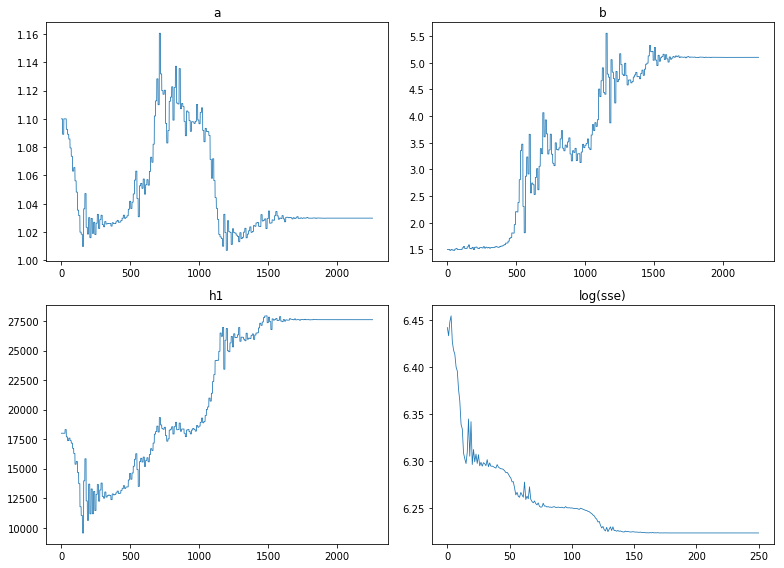

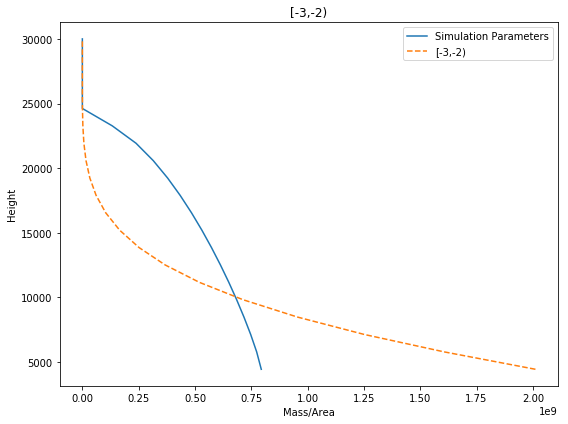

========[-2,-1)========
a* = -3.42951	b* = 0.89303            	h1* = 2.48732
a = 1.03240	b = 3.44253	h1 = 27606.87651
Success: True, Optimization terminated successfully.
Iterations: 99
SSE: 540.642620383633


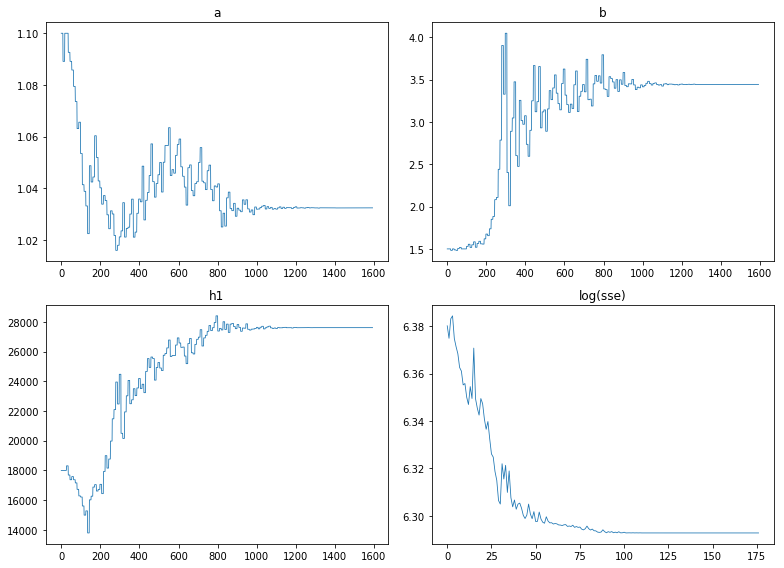

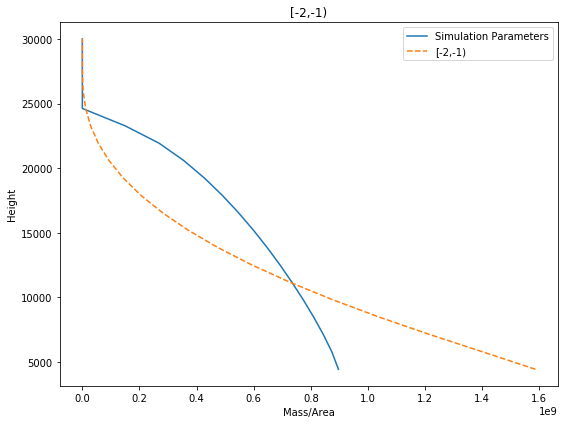

========[-1,0)========
a* = -3.34290	b* = 0.76167            	h1* = 2.42627
a = 1.03533	b = 3.14184	h1 = 27462.77502
Success: True, Optimization terminated successfully.
Iterations: 77
SSE: 570.9225335353422


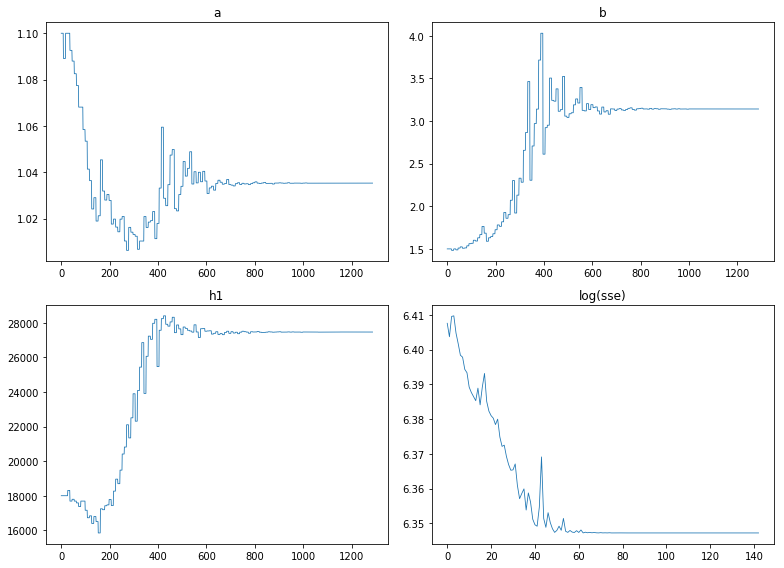

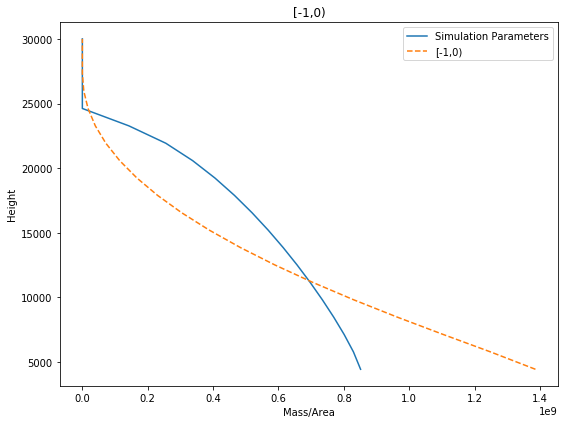

========[0,1)========
a* = -3.17885	b* = 0.31234            	h1* = 2.47342
a = 1.04163	b = 2.36662	h1 = 27574.76081
Success: True, Optimization terminated successfully.
Iterations: 89
SSE: 412.5942817746599


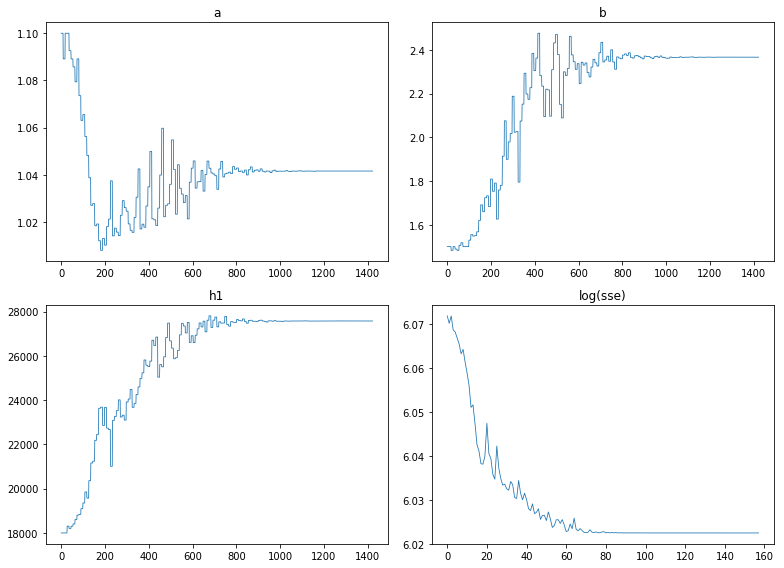

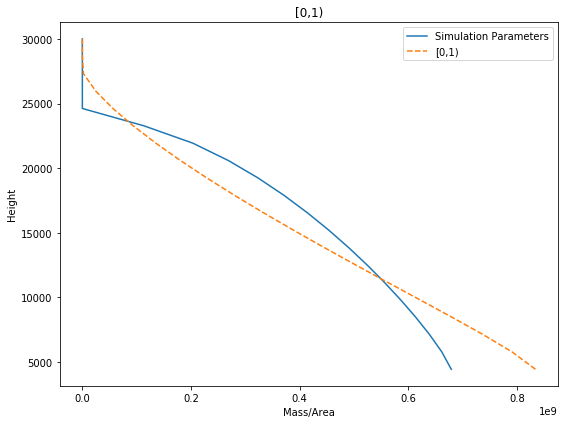

========[1,2)========
a* = -2.49518	b* = -1.17501            	h1* = 2.54736
a = 1.08248	b = 1.30882	h1 = 27740.94715
Success: True, Optimization terminated successfully.
Iterations: 87
SSE: 192.7609388791082


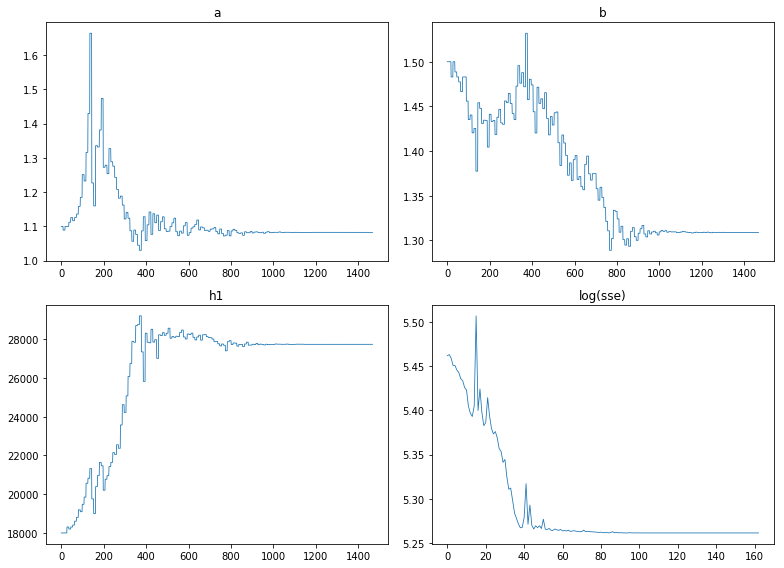

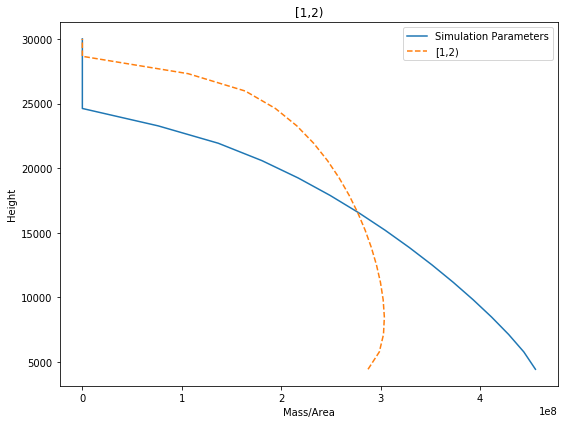

========[2,3)========
a* = -2.59960	b* = -0.92918            	h1* = 2.57575
a = 1.07430	b = 1.39488	h1 = 27801.79666
Success: True, Optimization terminated successfully.
Iterations: 85
SSE: 119.05116000220515


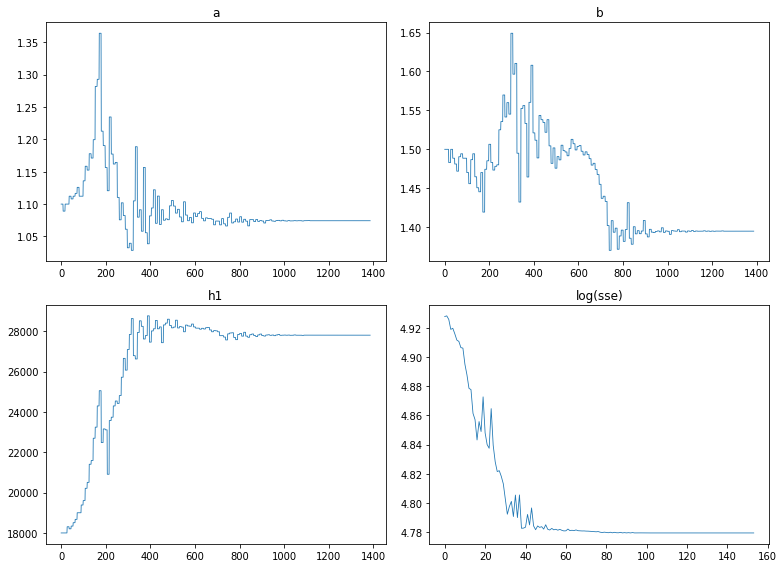

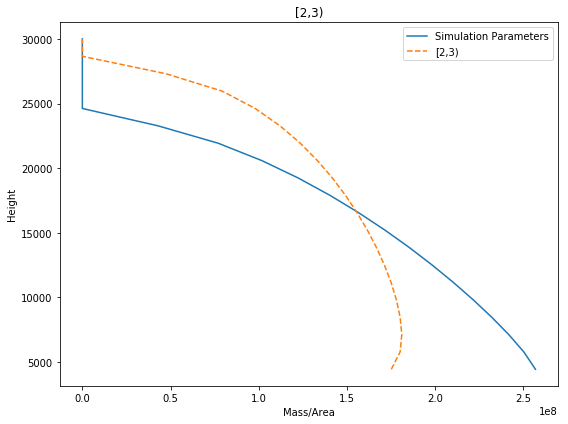

========[3,4)========
a* = -3.38917	b* = 0.92272            	h1* = 2.62456
a = 1.03374	b = 3.51612	h1 = 27902.76136
Success: True, Optimization terminated successfully.
Iterations: 90
SSE: 77.05047703554902


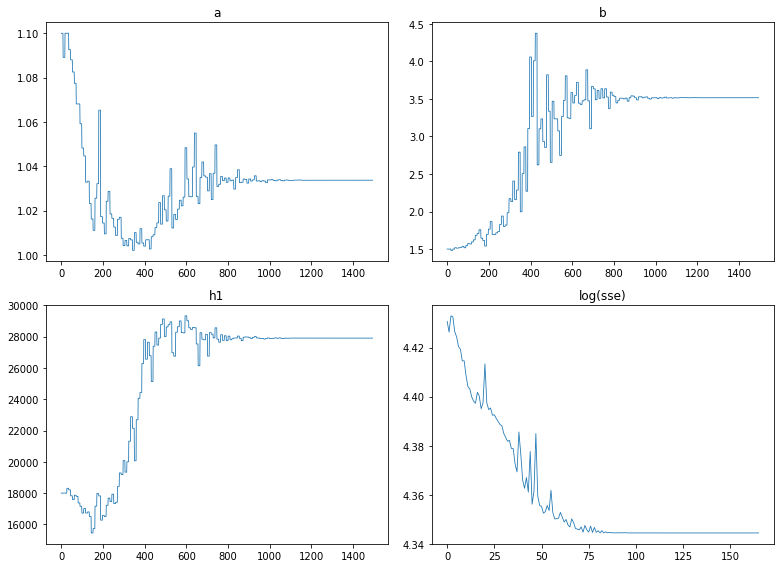

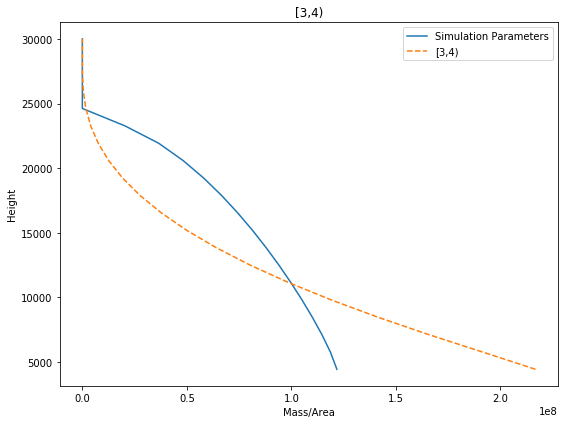

In [34]:
df = obs_df


priors_vals = {
    "a": 1.1,
    "b": 1.5,
    "h1": 18000
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True
}

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []
for phi_step in phi_steps:
    
    phi_df = df.copy()
    
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    
    print("========%s========"%phi_step["interval"])
    out = gaussian_stack_inversion(
        phi_df, len(phi_df), 20, config["VENT_ELEVATION"], H, 2500,
        mass_in_phi,(u,v),
        phi_steps, config["DIFFUSION_COEFFICIENT"],
        config["FALL_TIME_THRESHOLD"], config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          mass_in_phi, 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
#     display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    
    plt.tight_layout()
    plt.show()
     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                mass_in_phi)

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()

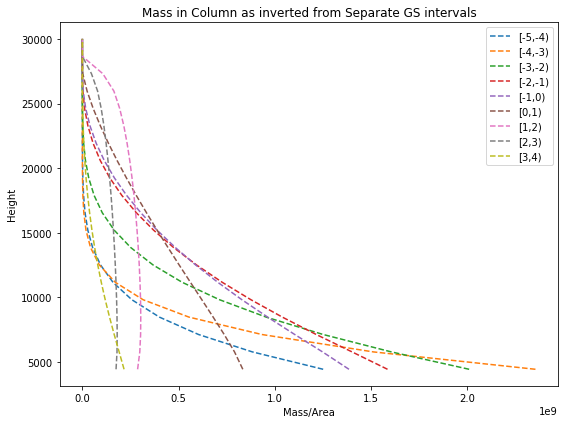

In [33]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

# ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for phi_step, mass in zip(phi_steps, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=phi_step["interval"])
ax1.legend()
ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()